# Client Convert-To-Paid (CTP) Prediction

The client (anonymized) is an ed-tech platform focused on personalized early learning for children ages 2-8. Using data collected on consumer trial periods (each trial spanning one month), our goal is to write a program that predicts whether a consumer will convert to a paid customer (CTP = 1) or not (CTP = 0) at the end of their free trial.

The Notebook will contain the following:

1. Data Exploration
2. Data Preprocessing
3. Model Training and Evaluation
4. Project Conclusion
5. Tangential Analytics: Effect of Hyperparameters on Model Performance

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
file_path = '~/Desktop/client_clean.csv'

client_data = pd.read_csv(file_path)

In [3]:
client_data.head()

,userid,path_type,multi_user_label,single_user,multiple_user,total_events,completed_count,completed_cat,not_completed_count,event_count_cat,...,pop_event_day,pop_title,pop_category,distinct_titles,title_count_cat,max_row,max_column,avg_row,avg_col,ctp
0,-9.219518e+18,"alc, pathways",Single-user,1,0,36,25,med,8,medium,...,Saturday,Letter Hunt,GAM,24,high,1.0,25.0,1.0,9.0,1
1,-9.218149e+18,pathways,Single-user,1,0,5,4,low,0,low,...,Sunday,Letter Hunt,NaN,2,low,NaN,NaN,NaN,NaN,0
2,-9.217416e+18,"alc, pathways",Single-user,1,0,59,36,med,21,high,...,Friday,"Make the Letters: A,a",NaN,39,high,20.0,16.0,3.0,4.0,0
3,-9.217257e+18,"alc, pathways",Single-user,1,0,126,111,very_high,14,very high,...,Thursday,Swimmy,RAS,87,very high,21.0,15.0,4.0,4.0,1
4,-9.212743e+18,"alc, pathways",Multiple-user,0,1,144,105,very_high,35,very high,...,Tuesday,The Airport,NaN,87,very high,28.0,16.0,2.0,3.0,1


# 1. Data Exploration

Plan of action:

1. Take a look and inspect all the columns to have an understaind of the dataset
2. Ivestigate characteristics of the data, including distribution of features
3. Establish the "baseline" conversion rate (free trial to CPT = 1) - in other words, what % of people convert to paid in the first place? This is subsequently the accuracy we would achieve by guessing CTP = 1 all of the time (or CTP = 0 all of the time - whatever is majority). This is also the accuracy we will aim to beat with our model.
4. Explore the relationships between categorical / continuous variables to the target variable. (These findings are summarized below as they were code intensive) 

In [4]:
client_data.shape

(5834, 46)

In [5]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5834 entries, 0 to 5833
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   userid                  5834 non-null   float64
 1   path_type               5834 non-null   object 
 2   multi_user_label        5834 non-null   object 
 3   single_user             5834 non-null   int64  
 4   multiple_user           5834 non-null   int64  
 5   total_events            5834 non-null   int64  
 6   completed_count         5834 non-null   int64  
 7   completed_cat           5834 non-null   object 
 8   not_completed_count     5834 non-null   int64  
 9   event_count_cat         5834 non-null   object 
 10  device_cat              5834 non-null   object 
 11  ipad_event              5834 non-null   int64  
 12  iphone_event            5834 non-null   int64  
 13  ipod_event              5834 non-null   int64  
 14  max_stage_complete      5263 non-null   

In [6]:
missing = pd.concat([client_data.isnull().sum(), 100 * client_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)


,count,%
pop_category,4994,85.601646
avg_row,2375,40.709633
avg_col,2368,40.589647
max_column,2368,40.589647
max_row,2368,40.589647
pathways_complete_rank,571,9.787453
max_stage_complete,571,9.787453
avg_cluster,553,9.478917
max_stage,553,9.478917
pathways_reach_rank,553,9.478917


We have several features with missing values in our dataset. To address this, we will first examine the correlation of these features with CTP during the exploratory analysis. This will help us assess their importance and determine the most effective approach for handling the missing values. 

- ie. can we impute missing values in a reasonable way or should they be dropped altogether. 

Afterwards we will deal with missing values in the preprocessing stage.

In [7]:
client_data['max_days_into_trial'].describe()

count    5834.000000
mean       13.122043
std        11.508560
min         0.000000
25%         1.000000
50%        12.000000
75%        25.000000
max        31.000000
Name: max_days_into_trial, dtype: float64

In [8]:
#Calculate benchmark CTP rate

ctp_counts = client_data['ctp'].value_counts()
ctp_counts

1    3953
0    1881
Name: ctp, dtype: int64

In [9]:
baseline = client_data['ctp'].value_counts()[1]/client_data['ctp'].value_counts().sum()

print(f'Baseline conversion is {baseline:.4f}')
uniqueusers = client_data['userid'].nunique()
print(f'Distinct users is {uniqueusers}')

Baseline conversion is 0.6776
Distinct users is 5834


Calculate Conversion Rates for CTP for categorical variables:

In [10]:
#visualize results to investigate relationships
def conversion_calc(df, column, plot=True):
    if plot:
        plt.rcParams['figure.figsize'] = (7,45)
        figure, axes = plt.subplots(len(categorical_columns))
    for i in range(0, len(categorical_columns)):
        category = column[i]
        grouped = df.groupby([category,'ctp'])[['ctp']].count().rename(columns={'ctp':'count'}).reset_index()
        grouped['total']=[grouped[grouped[category]==element]['count'].sum() for element in grouped[category]]
        grouped['conversion'] = grouped['count']/grouped['total']
        if plot:
            mypalette = (sns.cubehelix_palette(8, start=.5, rot=-.75))
            sns.barplot(grouped[category], grouped['conversion'], hue = grouped['ctp'], ax = axes[i], palette = {1:'#8bdab2',0:'#348fa7'}, alpha = 0.8)
            axes[i].title.set_text(column[i])
            axes[i].set_xlabel('')
            axes[i].legend(loc='upper left')
            figure.subplots_adjust(hspace = 0.37)
        else:
            return grouped


In [11]:
#visualize distribution of continuous variables, separated by CTP
def plot_continuous(df, continuous_columns):
    plt.rcParams['figure.figsize'] = [7, 40]
    figure, axes = plt.subplots(len(continuous_columns))
    for i, col in enumerate(continuous_columns):
        ctp_1 = df.loc[df['ctp']==1]
        ctp_0 = df.loc[df['ctp']==0]
        sns.distplot(ctp_0[col], hist = False, kde_kws={'shade':True}, ax = axes[i], color = '#348fa7')
        sns.distplot(ctp_1[col], hist = False, kde_kws={'shade':True}, ax = axes[i], color = '#8bdab2')
        axes[i].title.set_text(col)
        axes[i].set_xlabel('')
        axes[i].legend([0,1],loc='upper left')
        figure.subplots_adjust(hspace = 0.37)

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

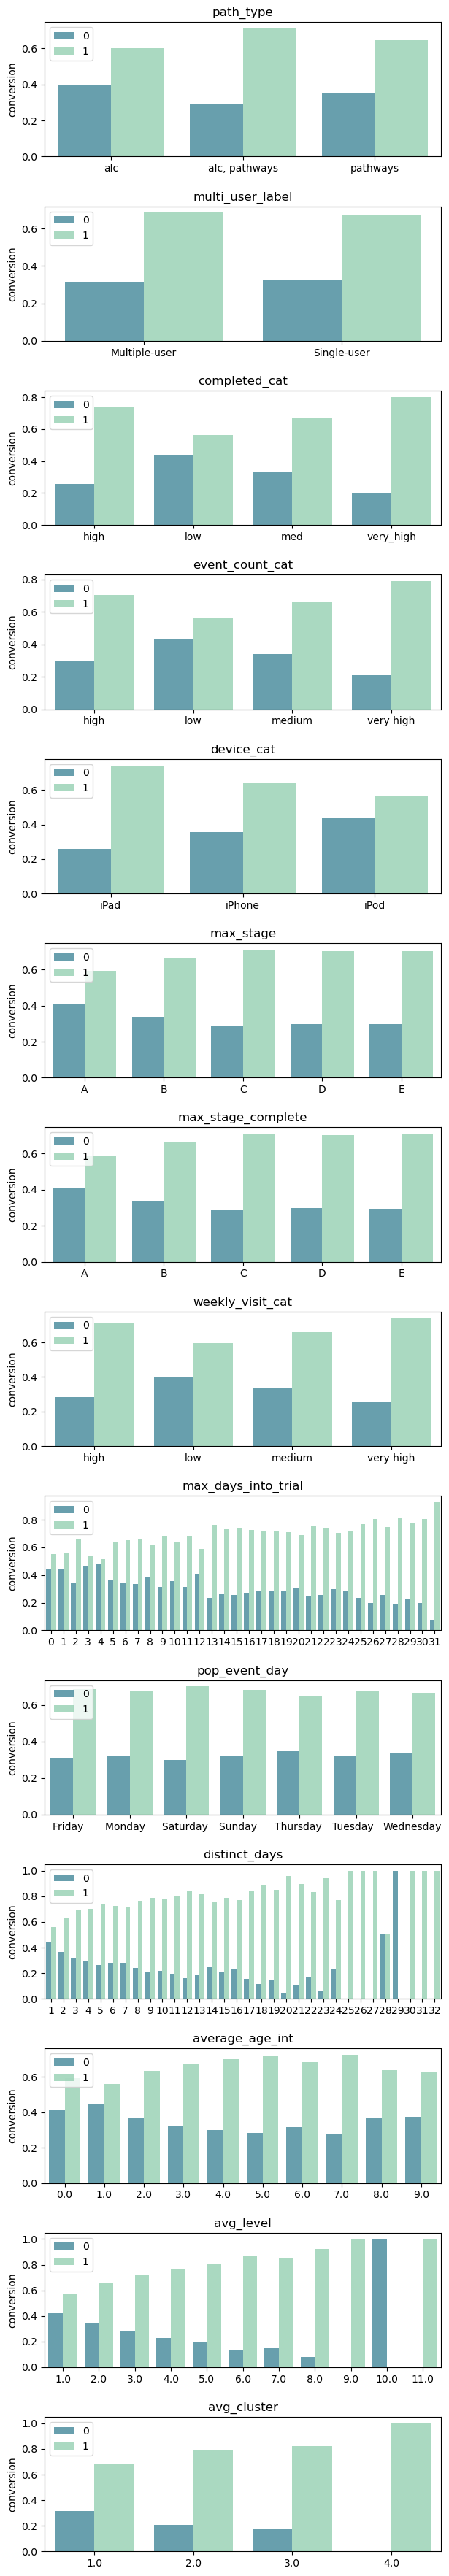

In [12]:
#Lets finally take a look at the visuals

categorical_columns = ['path_type','multi_user_label','completed_cat','event_count_cat',
                      'device_cat','max_stage','max_stage_complete','weekly_visit_cat','max_days_into_trial','pop_event_day',
                      'distinct_days', 'average_age_int', 'avg_level','avg_cluster']

conversion_calc(client_data, categorical_columns, plot=True)

As we saw previously, generally our client has a great conversion rate (67%). Visualizing the relation with conversion and the above categorical variables showcases some of the assumptions we might have coming into the Analysis. Typically, conversion is higher the further along a customer is in the trial, if they have participated in events, number of visits etc.  

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

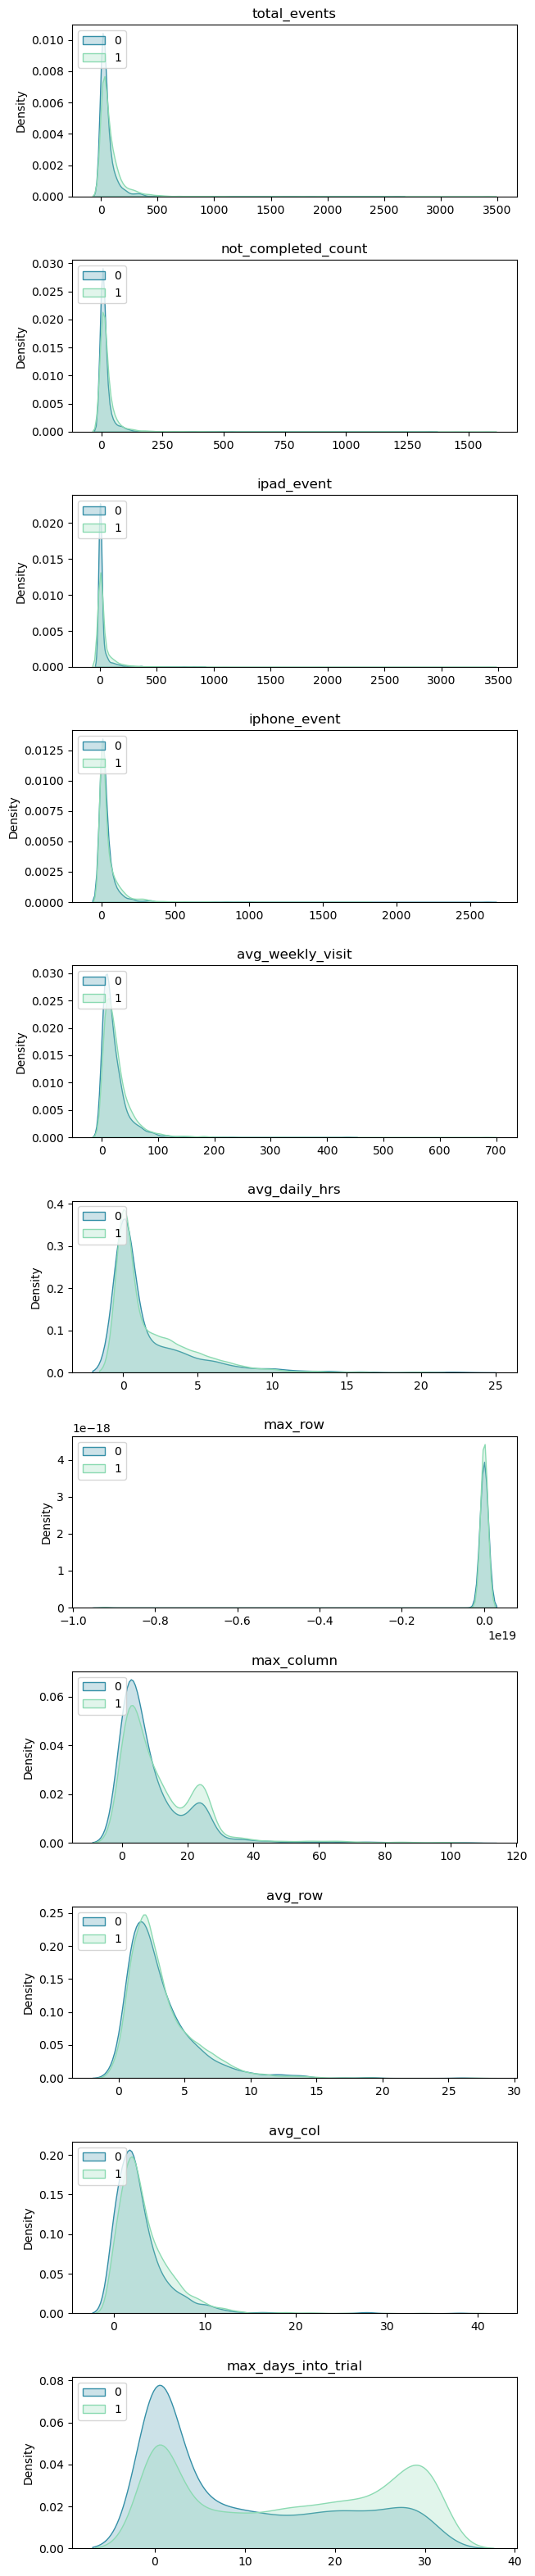

In [13]:

continuous_columns = ['total_events','not_completed_count','ipad_event','iphone_event','avg_weekly_visit',
                     'avg_daily_hrs','max_row','max_column','avg_row','avg_col','max_days_into_trial']

plot_continuous(client_data, continuous_columns)

# 2. Data Preprocessing

- Address NULL values.
- Make dummy variables for categorical variables.
- Create a feature that captures whether a user read one of the top 20 titles ("top" being defined as a title corresponding with a high CTP conversion rate).


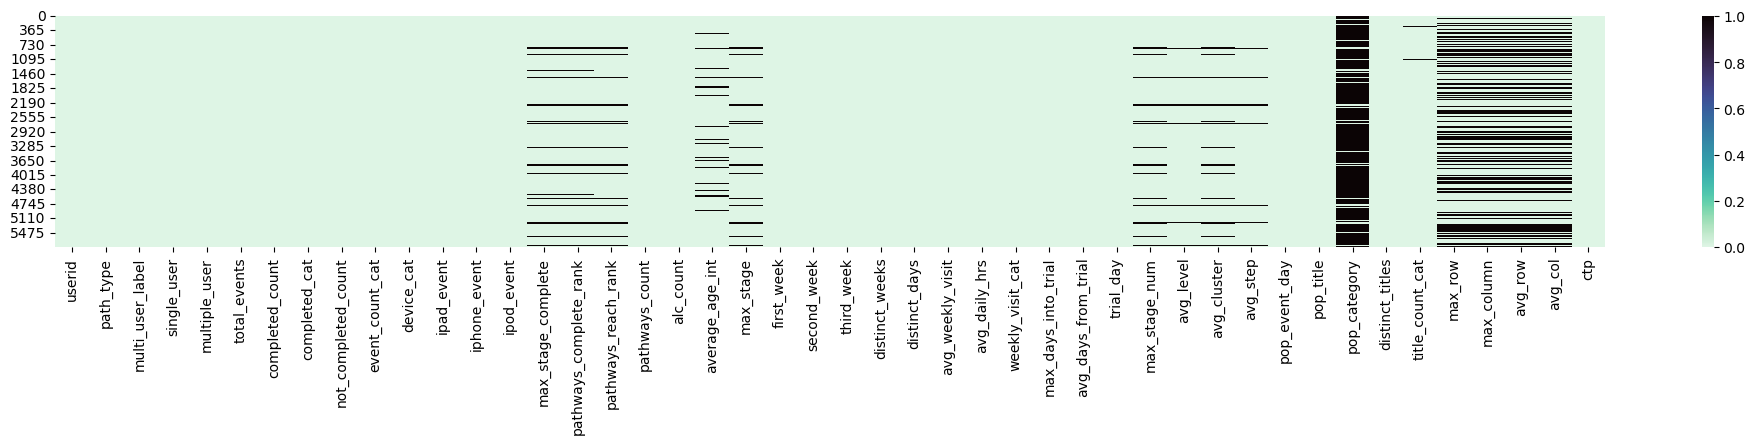

In [14]:
#Display missing values before and after removing unecessary columns
plt.rcParams['figure.figsize'] = (25,3)
mypalette = (sns.cubehelix_palette(8, start=.5, rot=-.75))
sns.heatmap(client_data.isnull(), cmap='mako_r')
plt.show()

Since the following columns don't seem to have any correlation with CTP according to the exploratory analysis, we will drop these columns

In [15]:
client_clean = client_data.drop(['max_row','max_column','avg_row','avg_col','pop_category'],inplace = False, axis = 1)

In [16]:
missing = pd.concat([client_clean.isnull().sum(), 100 * client_clean.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
max_stage_complete,571,9.787453
pathways_complete_rank,571,9.787453
max_stage,553,9.478917
avg_cluster,553,9.478917
max_stage_num,553,9.478917
pathways_reach_rank,553,9.478917
average_age_int,434,7.439150
avg_step,295,5.056565
avg_level,295,5.056565
title_count_cat,37,0.634213


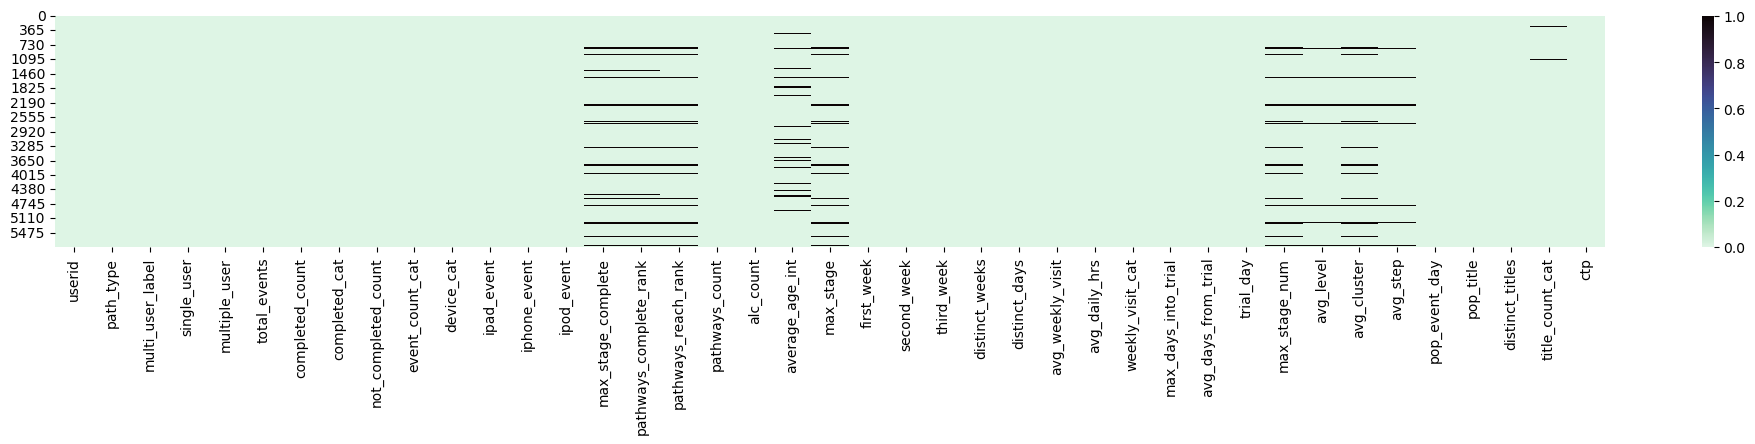

In [17]:
sns.heatmap(client_clean.isnull(), cmap='mako_r')
plt.show()

As the remaining columns with missing values all have less than 10% missing, we will impute them using different strategies given the type of feature:

In [18]:
# First let's isolate just for columns that have actual missing values
missing_columns = missing[missing['%'] > 0]
missing_columns

,count,%
max_stage_complete,571,9.787453
pathways_complete_rank,571,9.787453
pathways_reach_rank,553,9.478917
average_age_int,434,7.439150
max_stage,553,9.478917
max_stage_num,553,9.478917
avg_level,295,5.056565
avg_cluster,553,9.478917
avg_step,295,5.056565
title_count_cat,37,0.634213


As there is less than 10% of data missing in most columns where data is in fact missing, we will go ahead and impute these values to feed our model as the database already contains less data than normal. 

We will use the mean to impute numeric columns, and the most frequent value to fill the categorical values:

**Note** - We could complete this process programtically, but this piece of code is being used as a demonstration of process.

In [19]:
client_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5834 entries, 0 to 5833
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   userid                  5834 non-null   float64
 1   path_type               5834 non-null   object 
 2   multi_user_label        5834 non-null   object 
 3   single_user             5834 non-null   int64  
 4   multiple_user           5834 non-null   int64  
 5   total_events            5834 non-null   int64  
 6   completed_count         5834 non-null   int64  
 7   completed_cat           5834 non-null   object 
 8   not_completed_count     5834 non-null   int64  
 9   event_count_cat         5834 non-null   object 
 10  device_cat              5834 non-null   object 
 11  ipad_event              5834 non-null   int64  
 12  iphone_event            5834 non-null   int64  
 13  ipod_event              5834 non-null   int64  
 14  max_stage_complete      5263 non-null   

In [20]:
missing_numeric_columns = ['pathways_complete_rank', 'pathways_reach_rank','average_age_int', 'max_stage_num', 'avg_level', 'avg_cluster', 'avg_step']

In [21]:
missing_categorical_columns = ['max_stage_complete', 'max_stage', 'title_count_cat']

In [22]:
#Impute missing values for numeric columns

for col in missing_numeric_columns:
    client_clean[col].fillna(client_clean[col].mean(), inplace=True)

In [23]:
# For categorical columns: use most frequent value
for col in missing_categorical_columns:
    client_clean[col].fillna(client_clean[col].mode()[0], inplace=True)

In [24]:
missing_info = client_clean.isnull().sum()
missing_info

userid                    0
path_type                 0
multi_user_label          0
single_user               0
multiple_user             0
total_events              0
completed_count           0
completed_cat             0
not_completed_count       0
event_count_cat           0
device_cat                0
ipad_event                0
iphone_event              0
ipod_event                0
max_stage_complete        0
pathways_complete_rank    0
pathways_reach_rank       0
pathways_count            0
alc_count                 0
average_age_int           0
max_stage                 0
first_week                0
second_week               0
third_week                0
distinct_weeks            0
distinct_days             0
avg_weekly_visit          0
avg_daily_hrs             0
weekly_visit_cat          0
max_days_into_trial       0
avg_days_from_trial       0
trial_day                 0
max_stage_num             0
avg_level                 0
avg_cluster               0
avg_step            

At this point we have imputed all of our missing values succesfull 

Find most commonly-read 20 titles

For these titles, find which ones have a conversion rate greater than our baseline of 67%

This indicates titles correlated with a notable CTP rate

In [25]:
alltitles = pd.Series(client_clean['pop_title'].unique())
top20titles = client_clean['pop_title'].value_counts().nlargest(n=20).index
pop_titles = client_clean[client_clean['pop_title'].isin(top20titles)]
percent = pop_titles['pop_title'].value_counts().sum()/client_clean.shape[0]
print(f'percent of total records with top 20 title: {percent}')

#find the titles that have CTP conversion > baseline (67%)
title_conversions = conversion_calc(pop_titles, ['pop_title'], False)
best_titles = title_conversions[title_conversions['conversion'] > baseline]['pop_title'].to_list()
print('top 20 most popular titles with high conversion are:')
for element in best_titles:
    print('  -'+element)


percent of total records with top 20 title: 0.7130613644154954
top 20 most popular titles with high conversion are:
  -Angelina: Our Favorite Time of Year is Spring
  -First Sound, Middle Sound
  -Friendship Fun
  -Let's Draw
  -Memory Game: Friends
  -Power Practice
  -Sounds Abound
  -Speed Read
  -Teamwork!
  -What's That Sound?


**Dummy Columns & Repeated Categories**

Dummy columns (or one-hot encoding) are used to convert categorical variables into a format that can be provided to machine learning algorithms, which often require numerical input. Each category in the original variable is converted into a new binary column.

**Example:** If path_type has values A, B, and C, then one-hot encoding will create three new columns:
- path_type_A
- path_type_B
- path_type_C

Repeated columns involve adding a prefix or suffix to the existing column names based on their values. This approach is often used to distinguish between similar categorical values or to avoid conflicts when combining datasets.

 **Example:** For a column completed_cat with categories low, med, high, you might transform it into:
- completed_cat_low
- completed_cat_med
- completed_cat_high

In [26]:
#get dummy columns for categorical variables and titles with high conversion (printed above)
dummy_columns = ['path_type','multi_user_label','device_cat','pop_event_day','pop_title']
repeat_categories = ['weekly_visit_cat','title_count_cat','event_count_cat','completed_cat',
                    'max_stage_complete','max_stage']
all_columns = dummy_columns + repeat_categories

#add column name to low/med/high columns so dummy names for these columns are unique
for column in repeat_categories:
    client_clean[column] = column + '_' + client_clean[column]

In [27]:
# Merge dummy variables to continuous variables for final dataset
non_top_titles = list(alltitles[~alltitles.isin(best_titles)])
client_clean['pop_title'] = client_clean['pop_title'].replace(to_replace = list(non_top_titles), value = None)
client_clean['pop_title'] = client_clean['pop_title'].replace(non_top_titles, None)
client_clean_dummies = pd.get_dummies(client_clean[all_columns], prefix = 'cat')
client_clean_noncat = client_clean[[column for column in client_clean.columns if column not in all_columns]]
final = pd.merge(client_clean_dummies, client_clean_noncat, left_index = True, right_index = True, how = 'outer')


In [28]:
#confirm all types are numeric and there no nulls
print(final.dtypes.unique())
print(final.isnull().sum().unique())
print(final.columns)

[dtype('uint8') dtype('float64') dtype('int64')]
[0]
Index(['cat_alc', 'cat_alc, pathways', 'cat_pathways', 'cat_Multiple-user',
       'cat_Single-user', 'cat_iPad', 'cat_iPhone', 'cat_iPod',
       'cat_Friday   ', 'cat_Monday   ', 'cat_Saturday ', 'cat_Sunday   ',
       'cat_Thursday ', 'cat_Tuesday  ', 'cat_Wednesday',
       'cat_Angelina: Our Favorite Time of Year is Spring',
       'cat_First Sound, Middle Sound', 'cat_Friendship Fun', 'cat_Let's Draw',
       'cat_Memory Game: Friends', 'cat_Power Practice', 'cat_Sounds Abound',
       'cat_Speed Read', 'cat_Teamwork!', 'cat_What's That Sound?',
       'cat_weekly_visit_cat_high', 'cat_weekly_visit_cat_low',
       'cat_weekly_visit_cat_medium', 'cat_weekly_visit_cat_very high',
       'cat_title_count_cat_high', 'cat_title_count_cat_low',
       'cat_title_count_cat_med', 'cat_title_count_cat_very high',
       'cat_event_count_cat_high', 'cat_event_count_cat_low',
       'cat_event_count_cat_medium', 'cat_event_count_cat_ver

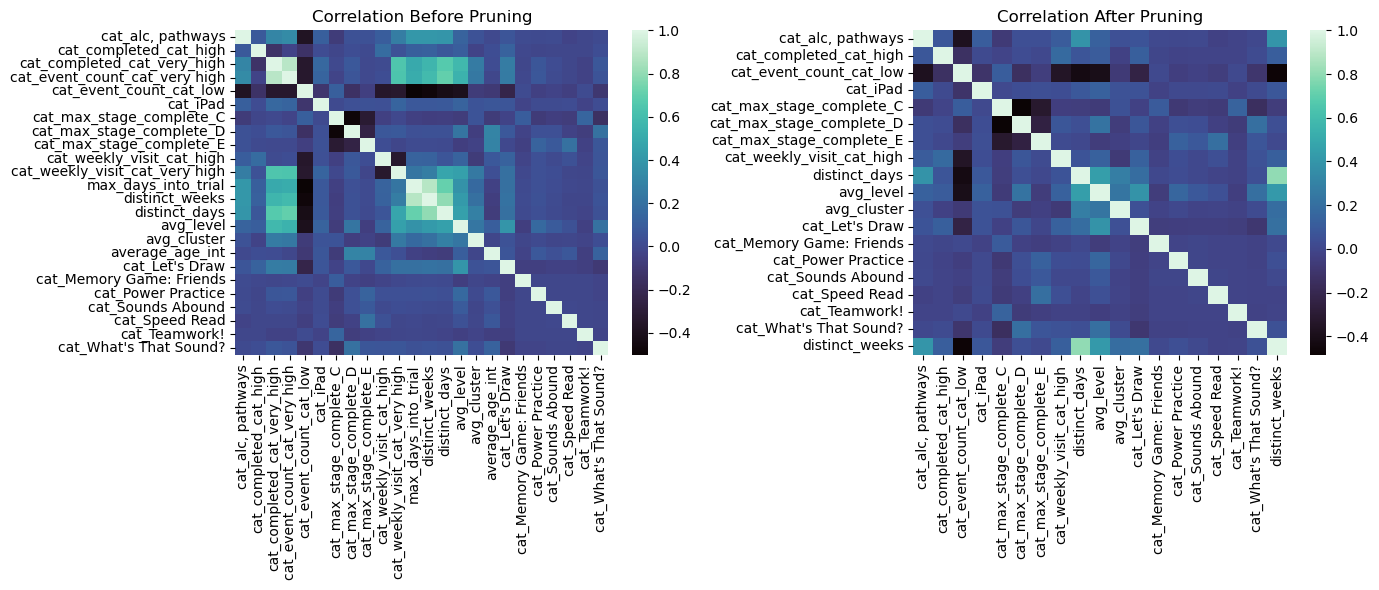

In [29]:
#Heatmap to visualize correlation among dependent variables
figure, subaxes = plt.subplots(1,2,figsize=(14,6))
sns.heatmap(final[['cat_alc, pathways', 'cat_completed_cat_high','cat_completed_cat_very_high','cat_event_count_cat_very high',
      'cat_event_count_cat_low','cat_iPad','cat_max_stage_complete_C', 'cat_max_stage_complete_D', 'cat_max_stage_complete_E',
      'cat_weekly_visit_cat_high','cat_weekly_visit_cat_very high', 'max_days_into_trial','distinct_weeks', 'distinct_days',
      'avg_level', 'avg_cluster', 'average_age_int', "cat_Let's Draw", 'cat_Memory Game: Friends', 'cat_Power Practice', 'cat_Sounds Abound', 'cat_Speed Read',
       'cat_Teamwork!', "cat_What's That Sound?"]].corr(), cmap='mako', ax=subaxes[0])
subaxes[0].set_title('Correlation Before Pruning')

#Heatmap to visualize correlation after removing variables that are highly correlated
#This is to prevent against multicollinearity, which can affect the calculation of individual predictors
sns.heatmap(final[['cat_alc, pathways', 'cat_completed_cat_high',
      'cat_event_count_cat_low','cat_iPad','cat_max_stage_complete_C', 'cat_max_stage_complete_D', 'cat_max_stage_complete_E',
      'cat_weekly_visit_cat_high','distinct_days',
      'avg_level', 'avg_cluster',  "cat_Let's Draw", 'cat_Memory Game: Friends', 'cat_Power Practice', 'cat_Sounds Abound', 'cat_Speed Read',
       'cat_Teamwork!', "cat_What's That Sound?",'distinct_weeks']].corr(), cmap = 'mako', ax = subaxes[1])
subaxes[1].set_title('Correlation After Pruning')
plt.tight_layout()
plt.show()

In [30]:
#Define final independent variables (X) and final dependent variable (y)
X = final[['cat_alc, pathways', 'cat_completed_cat_high',
      'cat_event_count_cat_low','cat_iPad','cat_max_stage_complete_C', 'cat_max_stage_complete_D', 'cat_max_stage_complete_E',
      'cat_weekly_visit_cat_high','distinct_days',
      'avg_level', 'avg_cluster',  "cat_Let's Draw", 'cat_Memory Game: Friends', 'cat_Power Practice', 'cat_Sounds Abound', 'cat_Speed Read',
       'cat_Teamwork!', "cat_What's That Sound?",'distinct_weeks']]
y = final['ctp']

# 3. Model Training and Evaluation

- Create a class to split the dataset into train/test sets, normalize the data, and fit various classification models
- We split the data into train/test sets so that we have one collection to fit our model on and preserve another set to make predictions and evaluate model accuracy. We also normalize the data since many classifications are sensitive to the distribution of features
- Models include: K-Nearest Neighbors, Logistic Regression, and Random Forest
- Each method that fits a model uses grid search to tune hyperparameters and find the model with the best fit (random search would be faster and probably just as effective, but we use grid search - which will test more parameters - so that we can more thoroughly investigate the effect of parameters on performance in Section 5). They also have the functionality to return a df with the parameters and the accuracy score of all models trained during the grid search to allow for investigation into how each of the parameters affect model results (Section 5).

In [31]:
class Model:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test, self.X_train_scaled, self.X_test_scaled = self.split_scale_data()
        
        
    def split_scale_data(self):
        X=self.X
        y=self.y
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return (X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)
        
        
    def rs_knn(self, scaled=True, df=False):
        X_train = self.X_train
        X_test = self.X_test
        X_train_scaled = self.X_train_scaled
        X_test_scaled = self.X_test_scaled
        y_train = self.y_train
        y_test = self.y_test
    
        knn_results = []
        knn = KNeighborsClassifier()
        params_knn = [{'weights':['uniform','distance'],
                  'n_neighbors':range(1,15),
                      'n_jobs':[None, -1,2]}]
        rs_knn = GridSearchCV(knn, param_grid = params_knn, cv = 5)
        if scaled:
            rs_knn.fit(X_train_scaled, y_train)
            knn_results=['KNN',KNeighborsClassifier(),rs_knn.best_params_, rs_knn.best_score_]
            if df:
                knn_df = pd.DataFrame(rs_knn.cv_results_).iloc[:,4:]
            else:
                knn_df = None
        else:
            rs_knn.fit(X_train, y_train)
            knn_results=['KNN',KNeighborsClassifier(),rs_knn.best_params_, rs_knn.best_score_]
            if df:
                knn_df = pd.DataFrame(rs_knn.cv_results_).iloc[:,4:]
            else:
                knn_df = None
        return knn_results, knn_df

    
    def rs_logistic(self, scaled=True, df=False):
        X_train = self.X_train
        X_test = self.X_test
        X_train_scaled = self.X_train_scaled
        X_test_scaled = self.X_test_scaled
        y_train = self.y_train
        y_test = self.y_test
    
        log_results = []
        log = LogisticRegression()
        params_log = [{'penalty':['l2'],
                  'C':[10**n for n in range (-10,10)],
                      'max_iter':[100, 200, 300,400],
                      'solver':['lbfgs', 'liblinear']},
                     {'penalty':['l1'],
                  'C':[10**n for n in range (-10,10)],
                      'max_iter':[100, 200, 300,400,500],
                      'solver':['liblinear']}]
 
        rs_log = GridSearchCV(log, param_grid = params_log)
        if scaled:
            rs_log.fit(X_train_scaled, y_train)
            log_results=['Logistic Regression',LogisticRegression(),rs_log.best_params_, rs_log.best_score_]
            if df:
                log_df = pd.DataFrame(rs_log.cv_results_).iloc[:,4:]
            else:
                log_df = None
        else:
            rs_log.fit(X_train, y_train)
            log_results=['Logistic Regression',LogisticRegression(),rs_log.best_params_, rs_log.best_score_]
            if df:
                log_df = pd.DataFrame(rs_log.cv_results_).iloc[:,4:]
            else:
                log_df = None
        return log_results, log_df
    
    
    #note: you don't have to scale data with random forests, but a universal transformation of all features should not affect model results
    #we scale the data for consistency in later functions, which use scaled data to calculate model performance
    def rs_randomforest(self, df=False):
        X_train = self.X_train
        X_test = self.X_test
        X_train_scaled = self.X_train_scaled
        X_test_scaled = self.X_test_scaled
        y_train = self.y_train
        y_test = self.y_test
    
        rf_results = []
        rf = RandomForestClassifier()
        params_rf = [{'n_estimators':[100,200,300,400,500],
                       'criterion':['gini', 'entropy'],
                       'max_depth':[3,5,8,10,15,None],
                       'bootstrap':[True, False]}]
        rs_randomforest = GridSearchCV(rf, param_grid = params_rf)
        rs_randomforest.fit(X_train, y_train)
        rf_results = ['Random Forest',RandomForestClassifier(),rs_randomforest.best_params_, rs_randomforest.best_score_]
        if df:
            rf_df = pd.DataFrame(rs_randomforest.cv_results_).iloc[:,4:]
        else:
            rf_df = None
        return rf_results, rf_df

In [32]:
#Use random search to find the best KNN model, logistic classifier, and random forest
mymodel = Model(X,y)
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = mymodel.split_scale_data()
knn_results, knn_df = mymodel.rs_knn(scaled=True, df=True)
log_results, log_df = mymodel.rs_logistic(scaled=True, df=True)
rf_results, rf_df = mymodel.rs_randomforest(df=True)

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

Now we'll plot the confusion matrix and calculate the f1_score to compare the accuracy between models 

The F1 score is a measure of how accurate the model is, taking into account how often it is able to accurately predict classes with low occurance - in this case, CTP = 0


In [33]:
def model_comparison(**kwargs):
    scores = {}
    figure, subaxes = plt.subplots(1,len(kwargs), figsize = (9,3))
    for i, (k, v) in enumerate(kwargs.items()):
        model_name = k
        model_type = v[1]
        model_fit = model_type.set_params(**v[2]).fit(X_train_scaled, y_train)
        
        score = model_fit.score(X_test_scaled, y_test)
        y_predicted = model_fit.predict(X_test_scaled)
        f1 = f1_score(y_test, y_predicted)
        plot_confusion_matrix(model_fit, X_test_scaled, y_test, ax=subaxes[i], cmap='mako_r',normalize='all')
        subaxes[i].set_title(v[0])
        
        if v[0] == 'Logistic Regression':
            scores[v[0]] = (f1, score, model_fit.coef_[0])
        elif v[0] == 'Random Forest':
            scores[v[0]]=(f1, score, model_fit.feature_importances_)
        else:
            scores[v[0]]=(f1, score)
        print(f'{v[0]}: f1_score is {f1:.4f}, accuracy is {score:.4f}')
    plt.tight_layout()
    plt.show()
    return scores

def plot_importances(scores):
    figure, subplots = plt.subplots(1,2, figsize=(10,5))
    test = pd.DataFrame(list(zip(X_train.columns,scores['Random Forest'][2])), columns=['column','coef']).sort_values('coef', ascending=False)
    test_log = pd.DataFrame(list(zip(X_train.columns,scores['Logistic Regression'][2])), columns=['column','coef']).sort_values('coef', ascending=False)

    sns.barplot(test['coef'],test['column'], ax=subplots[0], palette='mako_r')
    subplots[0].set_title('RF Feature Ranking')
    sns.barplot(test_log['coef'],test_log['column'], ax=subplots[1], palette='mako_r')
    subplots[1].set_title('Logistic Feature Ranking')
    plt.tight_layout()

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

KNN: f1_score is 0.7683, accuracy is 0.6436
Logistic Regression: f1_score is 0.8080, accuracy is 0.6779
Random Forest: f1_score is 0.8080, accuracy is 0.6779


/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


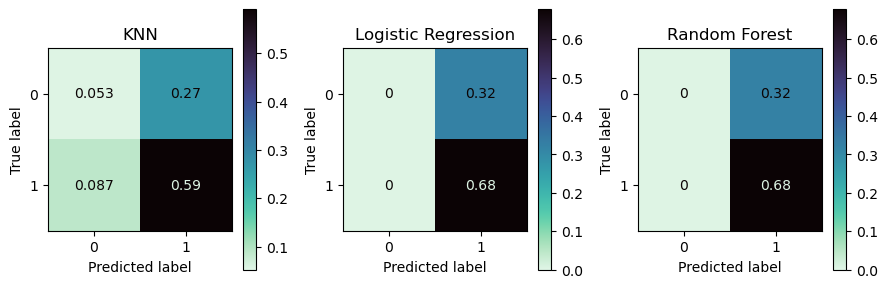

In [34]:
#model prediction: can make more sensitive to one direction or the other
scores = model_comparison(**{'knn':knn_results, 'log':log_results, 'rf':rf_results})

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


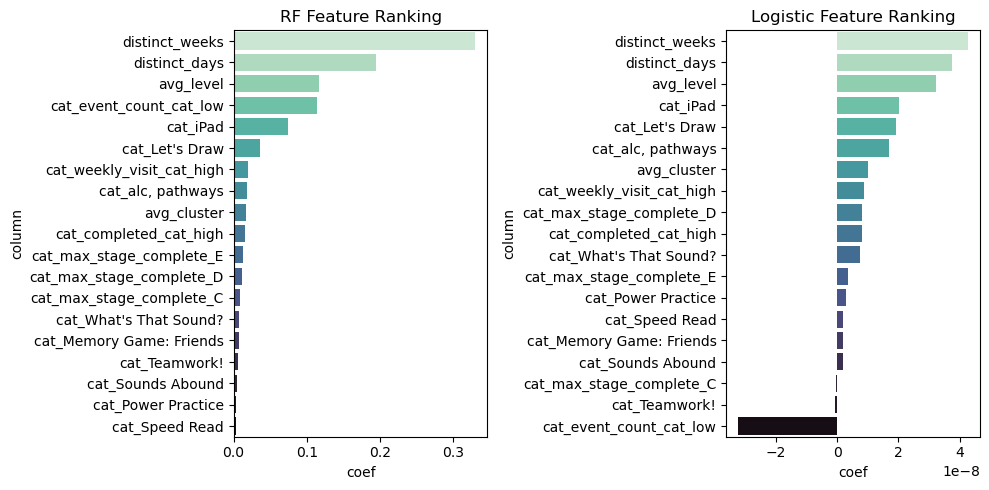

In [35]:
plot_importances(scores)

# 4. Project Conclusion

- Random forest slightly outperformed other models, with an F1 score of 82%. F1 score is a measure of how accurate the model is, taking into account how often it is able to accurately predict classes with low occurance - in this case, CTP = 0.
- However, the model's naked accuracy is 70%, which is only incrementally better than our baseline of 67%.
- Features that are most predictive of CTP are the the distinct number of weeks and days someone logged in, whether a customer utililzed the service through an Ipad, the average level a customer reached, the disctinct number of titles a customer read.

**Improvements that can be made**

- Improved feature engineering: further investigate relationship of features to others, narrow down which features to include or to augment with related data
- Using other classification techniques: XGBoost, LGBM classification, Support Vector Machines
- Augmenting with more demographic data about the consumer: geographic location, interests, gender, homeschooled or public / private school, etc
- Possible segmentation of models depending on consumer characteristics, like time the trial started (perhaps more likely to CTP in summer months, when school is off?), age (separate by those in school (4 yrs +) and those not in school (2-3 years)
- PCA to narrow features included
- use SMOTE to address class imbalance

**KNN:**

- In general, model accuracy increases as the number of neighbors used increases. If we were to graph this for accuracy on the training set, however, we might see a decline in accuracy after a certain threshold in number of neighbors.
- Using a uniform weight (in which neighbors are not weighted by their distance to the query point) yields higher average test score, but with greater variance - as model score is lower for those with an even number of neighbors (possibly due to ties in who the nearest neighbors are).
- The number of jobs doesn't impact model performance.

**Logistic Regression:**

- For both L1 Penalty (Lasso regression) and L2 Penalty (Ridge regression), the C parameter (higher C values = less severe penalization) has a strong effect on model performance.
- With L1 regularization, model performance increases significantly after C >= 0.01. The goal with Lasso regression is to prune insignificant variables - but values of C < 0.01 take this too far, discluding ALL features. Once C increases past 0.01, more features are included in the model, but they add low marginal improvement to the overall score.
- With L2 regularization, model performance is highly variable until C >=1, where scores converge to ~70%.
- The number of maximum iterations doesn't impact scores for Lasso regression or Ridge regression. However, the latter model has different performance depending on what type of solver is used - 'lgbfs' has higher scores and lower variability. I don't yet understand the difference between the solver types - need to look into this more.

**Random Forest:**

- The number of estimators does not have a signifcant impact on model performance.
- There's a slight impact on performance from bootstrapping, which slightly increases accuracy and decreases - variability in model scores.
- As the depth of the three increases, the model performance decreases. Using the 'entropy' criteria and bootstrapping the samples increases score.

K-Nearest Neighbors

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

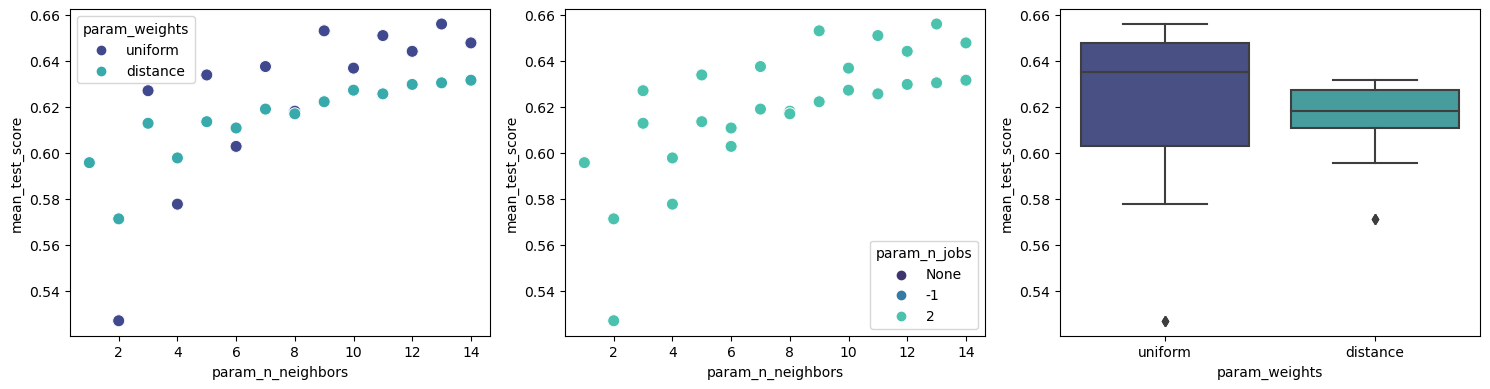

In [48]:
#How does the weighting metric, the number of neighbors, and the number of jobs affect KNN performance?
figure, subaxes = plt.subplots(1,3,figsize=(15,4))
sns.scatterplot(knn_df['param_n_neighbors'], knn_df['mean_test_score'], hue=knn_df['param_weights'],s=75,palette='mako', ax=subaxes[0])
sns.scatterplot(knn_df['param_n_neighbors'], knn_df['mean_test_score'], hue=(knn_df['param_n_jobs']).apply(str),s=75,palette='mako', ax=subaxes[1])
sns.boxplot(knn_df['param_weights'], knn_df['mean_test_score'],palette='mako', ax=subaxes[2])

plt.tight_layout()

Logistic Regression - 

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

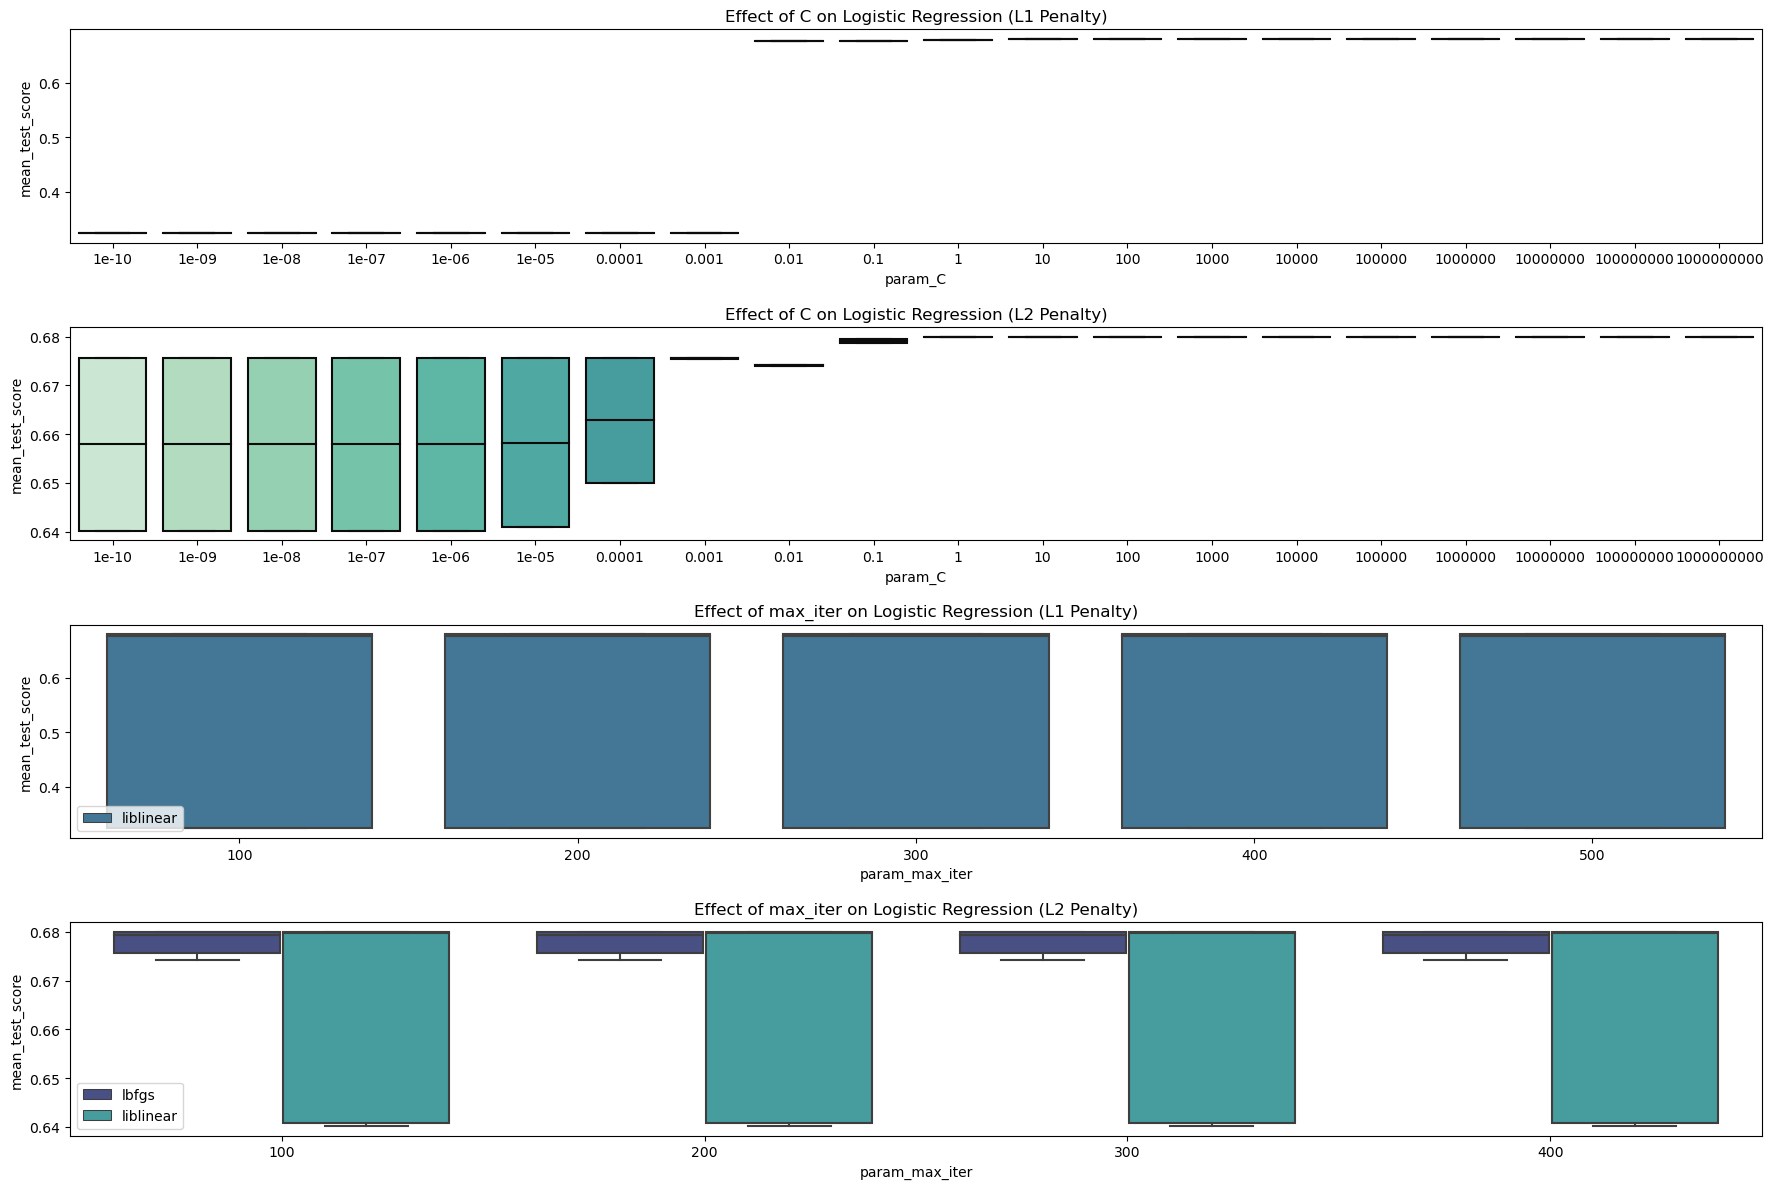

In [49]:
#How does the value of C affect performance for each of the two penalty types?
figure, subaxes=plt.subplots(4,1,figsize = (18,12))
l1 = log_df[log_df['param_penalty'] == 'l1']
sns.boxplot(l1['param_C'], l1['mean_test_score'],palette='mako_r',ax=subaxes[0])
subaxes[0].set_title('Effect of C on Logistic Regression (L1 Penalty)')

l2 = log_df[log_df['param_penalty'] == 'l2']
sns.boxplot(l2['param_C'], l2['mean_test_score'],palette='mako_r', ax=subaxes[1])
subaxes[1].set_title('Effect of C on Logistic Regression (L2 Penalty)')

#ow does the value of max_iter affect performance for each of the two penalty types?
sns.boxplot(l1['param_max_iter'], l1['mean_test_score'],hue = l1['param_solver'],palette='mako',ax = subaxes[2])
subaxes[2].legend(loc='lower left')
subaxes[2].set_title('Effect of max_iter on Logistic Regression (L1 Penalty)')
sns.boxplot(l2['param_max_iter'], l2['mean_test_score'],hue = l2['param_solver'],palette='mako', ax=subaxes[3])
subaxes[3].legend(loc='lower left')
subaxes[3].set_title('Effect of max_iter on Logistic Regression (L2 Penalty)')
figure.subplots_adjust(hspace = 10)
plt.tight_layout()

Random Forest - 

/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zivkodanicic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error

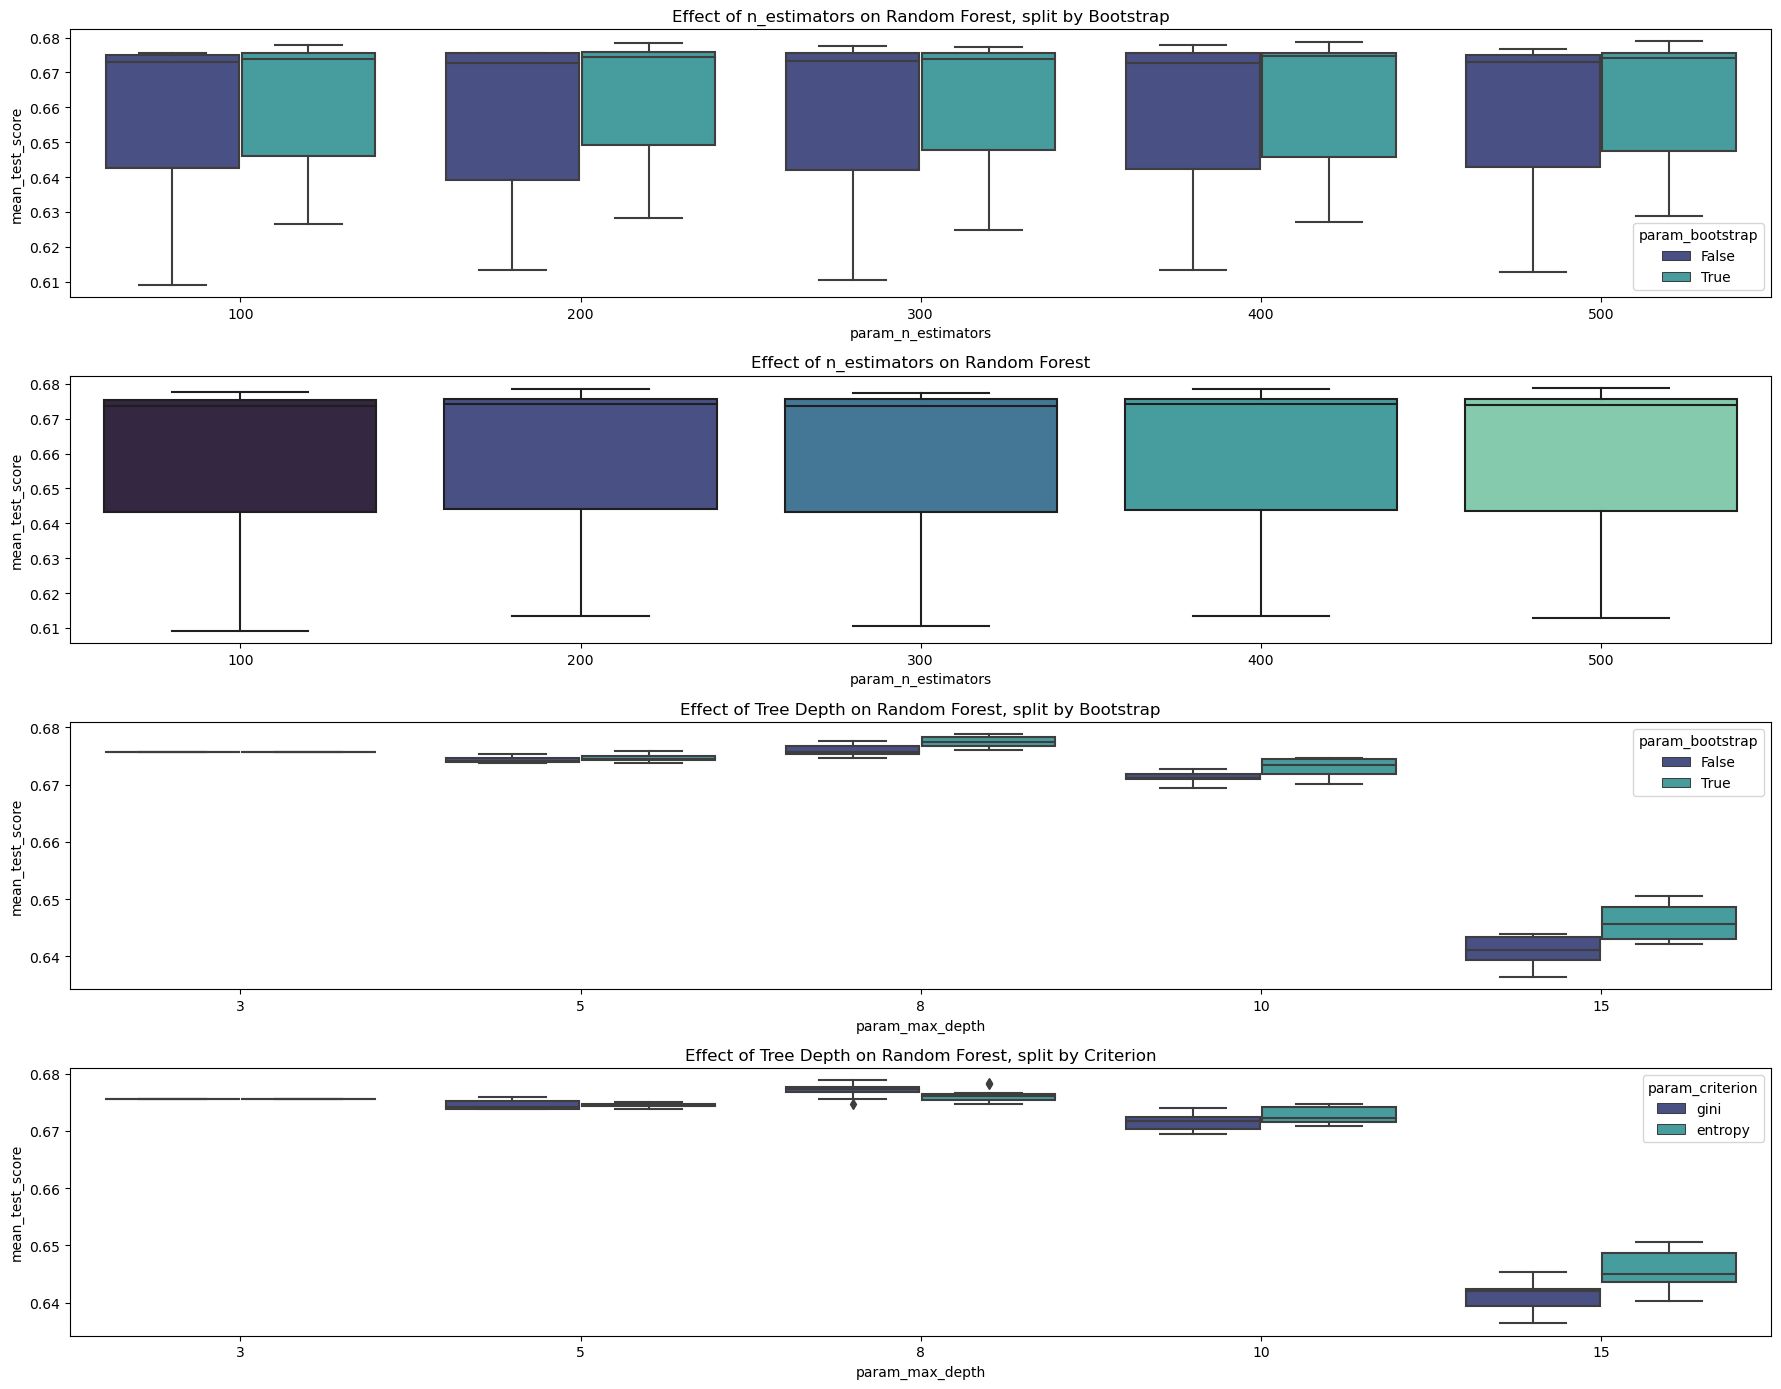

In [50]:
#How does the number of estimators, the depth of the tree, the bootstrap method, and the criterion method impact model performance?
figure, subaxes = plt.subplots(4,1,figsize=(18,14))
sns.boxplot(rf_df['param_n_estimators'], rf_df['mean_test_score'], hue=rf_df['param_bootstrap'], palette='mako', ax=subaxes[0])
subaxes[0].set_title('Effect of n_estimators on Random Forest, split by Bootstrap')
sns.boxplot(rf_df['param_n_estimators'], rf_df['mean_test_score'], palette='mako', ax=subaxes[1])
subaxes[1].set_title('Effect of n_estimators on Random Forest')
sns.boxplot(rf_df['param_max_depth'], rf_df['mean_test_score'], rf_df['param_bootstrap'],palette='mako', ax=subaxes[2])
subaxes[2].set_title('Effect of Tree Depth on Random Forest, split by Bootstrap')
sns.boxplot(rf_df['param_max_depth'], rf_df['mean_test_score'], rf_df['param_criterion'],palette='mako', ax=subaxes[3])
subaxes[3].set_title('Effect of Tree Depth on Random Forest, split by Criterion')
figure.subplots_adjust(hspace = 10)
plt.tight_layout()